# Vision Transformer

## overview
From the paper "AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"["AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"](https://arxiv.org/abs/2010.11929)

While the Transformer architecture has become the de-facto standard for natural
language processing tasks, its applications to computer vision remain limited. In
vision, attention is either applied in conjunction with convolutional networks, or
used to replace certain components of convolutional networks while keeping their
overall structure in place We show that this reliance on CNNs is not necessary
and a pure transformer applied directly to sequences of image patches can perform
very well on image classification tasks. When pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks
(ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent
results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.


This is a simplified PyTorch implementation of the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. The goal of this project is to provide a simple and easy-to-understand implementation. The code is not optimized for speed and is not intended to be used for production.


![vit_transformer](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In a vision transformer, an input image is divided into patches, and each patch is linearly projected into a lower-dimensional representation called embeddings. These embeddings are then fed into a transformer encoder, which consists of multiple layers of self-attention and feed-forward neural networks. The self-attention mechanism allows the model to capture global relationships between patches by attending to relevant information in other patches.
After passing through the transformer encoder, the resulting embeddings are classified using a linear layer or another type of classifier to predict the labels or perform other visual recognition tasks.

# Model

In [1]:
!pip install lightning
# !pip install pytorch-lightning -q
# install weights and biases
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.3 MB/s eta 0:00:00


In [2]:
!pip install torchmetrics

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import lightning.pytorch as pl

from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

import wandb

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## weight and bias login

In [4]:
wandb.login(key = os.environ['WANDB_API_KEY'])

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# model

let's create simple encoder architecture

In [5]:
dropout = 0.1
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, input_embd_dim, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_embd_dim,head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(input_embd_dim, input_embd_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_embd,n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



## let's create vit transformer
note:
1. Class token (Cls token) is added at 0 position. It serves as a learnable representation of the entire image and plays a crucial role in enabling the model to perform image-level classification. Cls token is later feed to feedforward network to do classification
2. Position embeddings are learned as additional parameters within the vision transformer architecture

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ViT(nn.Module):
    def __init__(self, image_size = 32, patch_size = 8, num_classes=10, hidden_dim = 256, num_heads = 8, num_layers=6):
        
        """
        image size : sizeof image
        patch size : patch size
        hidden_dim : embedding size of each patch 
        num_head: number of heads in each attention layer
        num_layers : total number of attention and feed forward layer
        """
        super(ViT, self).__init__()
        
        self.patch_size = patch_size
        #calculation number of patches
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2  # Assuming RGB images

        #for embedding patches
        self.patch_embedding = nn.Linear(patch_dim, hidden_dim)
        # cls token is used for classification
        self.cls_token = nn.Parameter(torch.randn(hidden_dim)) 
        
        # position embedding 
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches + 1, hidden_dim)) #num_patches +1  for cls token 
        self.vit_encoder = nn.Sequential(*[Block(hidden_dim, n_head=num_heads) for _ in range(num_layers)])

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, _, _, _ = x.shape

        x = self.transform_image_to_patch(x, self.patch_size) ## (b, no.of patches ,patch_dim)
        x = self.patch_embedding(x)                          ## (b,no.of patches, embedding_dim)

        # adding cls token
        b, n, d =x.shape 
        x_new = torch.zeros((b, n+1, d), device = DEVICE)              ## (b,no.of patches,1, embedding_dim)
        x_new[:,0,:] = self.cls_token
        x_new[:,1:,:] = x                           ## (b,no.of patches +1, embedding_dim)
        x_new += self.positional_encoding[:, :x_new.size(1)]         
        
        x_new = self.vit_encoder(x_new)  # (b, embedding_dim)
        #taking only class token
        cls = x_new[:,0,:]               # taking cls head part
        cls = self.fc(cls)
        return cls

    
    def transform_image_to_patch(self, input_image, patch_size):
        """ transform image to patchs"""
        input_image = input_image.permute(0,2,3,1)
        batch, image_height, image_width, channels = input_image.shape
        
        num_patches_h = image_height // patch_size
        num_patches_w = image_width // patch_size
        
        #zeros of shape(batch, number of patches, patch_height, patch_width, channel)
        patch_array = torch.zeros((batch, num_patches_h * num_patches_w, patch_size, patch_size, channels), device = DEVICE)

        for b in range(batch):
            patch_idx = 0
              
            for i in range(num_patches_h):
                  for j in range(num_patches_w):
                        
                        start_h = i * patch_size
                        start_w = j * patch_size
                        end_h = start_h + patch_size
                        end_w = start_w + patch_size

                        patch =input_image[b, start_h:end_h, start_w:end_w, :]
                        patch_array[b, patch_idx, :, :, :] = patch
                        patch_idx += 1
        
        #return channel*patch_size**2 i.e. embedding size
        return patch_array.reshape(batch, -1, 3 * patch_size ** 2).float()   # (b,no.of patches ,patch_dim)
    


## Data


We are using CIFAR10 dataset 

In [7]:
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 14056619.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Visualize some data

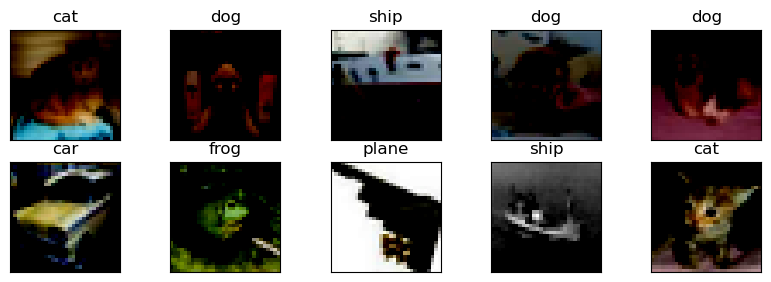

In [8]:


classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Pick 30 samples randomly
indices = torch.randperm(len(trainset))[:10]
images = [np.asarray(trainset[i][0]) for i in indices]
labels = [trainset[i][1] for i in indices]

# Visualize the images using matplotlib
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(np.array(images[i]), (1, 2, 0)) )
    ax.set_title(classes[labels[i]])

## Training model

In [9]:
from torchmetrics import Accuracy
from torch.utils.data import random_split
# import lightning. as pl
class LitVitas(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.save_hyperparameters()
        self.accuracy = Accuracy(task='multiclass', num_classes=10)
           
    def forward(self, inputs):
       
        return self.model(inputs)
    
    
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
     
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        return loss, acc
    
    def validation_step(self, batch, batch_idx):
 
        inputs, labels = batch
        logits =self(inputs)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def train_dataloader(self):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                                shuffle=True, num_workers=2)
        return trainloader
    
    def val_dataloader(self):
        valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
        
        train_set, val_set = random_split(valset, [int(len(valset)*0.9), len(valset) - int(len(valset)*0.9)])
        valloader = torch.utils.data.DataLoader(val_set, batch_size=32,
                                                    shuffle=False, num_workers=2)
        return valloader
    
    
    
    
    
    

In [10]:
from lightning import LightningModule
import lightning.pytorch as pl

wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')
lmodel = ViT()
model = LitVitas(lmodel)

early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

trainer = pl.Trainer(max_epochs=30,
                     logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                checkpoint_callback],
                     )

trainer.fit(model)



wandb: Currently logged in as: gt277966 (blank0). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in ./wandb/run-20230629_122418-izv7puab
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run grateful-frog-5
wandb: ⭐️ View project at https://wandb.ai/blank0/wandb-lightning
wandb: 🚀 View run at https://wandb.ai/blank0/wandb-lightning/runs/izv7puab
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | model    | ViT                | 4.8 M 
1 | accuracy | MulticlassAccuracy | 0     
-------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
trainer.test(model, testloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6292999982833862     │
│         test_loss         │    1.1238353252410889     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1238353252410889, 'test_acc': 0.6292999982833862}]

In [12]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
wandb:            test_acc ▁
wandb:           test_loss ▁
wandb:     train_acc_epoch ▁▃▃▄▅▅▅▆▆▆▇▇▇██
wandb:      train_acc_step ▃▂▁▂▄▅▁▄▅▃▅▅▅▆▅▆▅▇▃▅▅▆█▇▆▆▅▅▆▆▆▆▇▆▆██▇▆█
wandb:    train_loss_epoch █▆▅▅▄▄▄▃▃▃▂▂▂▁▁
wandb:     train_loss_step █▇▇▆▅▅▇▄▄▇▄▄▅▄▅▄▄▂▄▄▄▃▃▃▅▄▃▃▃▃▃▃▂▃▃▂▁▂▃▂
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:             val_acc ▁▃▄▅▅▆▆▆▇▇▇█▇▇█
wandb:            val_loss █▆▅▃▄▃▃▃▂▂▂▁▃▃▃
wandb: 
wandb: Run summary:
wandb:               epoch 15
wandb:            test_acc 0.6293
wandb:           test_loss 1.12384
wandb:     train_acc_epoch 0.73828
wandb:      train_acc_step 0.8125
wandb:    train_loss_epoch 0.73875
wandb:     train_loss_step 0.62919
wandb: trainer/global_step 23445
wandb:             val_acc 0.62
wandb:            val_loss 1.21472
wandb: 
wandb: 🚀 View run grateful-frog-5 at: htt